In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import shutil

def rmtree(f: Path):
    if f.is_file():
        f.unlink()
    else:
        for child in f.iterdir():
            rmtree(child)
        f.rmdir()

In [3]:
base_path = Path('data/raw_data')
files = list(base_path.glob("*/*/*.*"))
files

[PosixPath('data/raw_data/tanpa_bola/take_269663/right_cam.jpg'),
 PosixPath('data/raw_data/tanpa_bola/take_269663/left_cam.jpg'),
 PosixPath('data/raw_data/tanpa_bola/take_441446/right_cam.jpg'),
 PosixPath('data/raw_data/tanpa_bola/take_441446/New Text Document.txt'),
 PosixPath('data/raw_data/tanpa_bola/take_441446/left_cam.jpg'),
 PosixPath('data/raw_data/tanpa_bola/take_238608/right_cam.jpg'),
 PosixPath('data/raw_data/tanpa_bola/take_238608/left_cam.jpg'),
 PosixPath('data/raw_data/bola/take_700692/right_cam.jpg'),
 PosixPath('data/raw_data/bola/take_700692/New Text Document.txt'),
 PosixPath('data/raw_data/bola/take_700692/left_cam.jpg'),
 PosixPath('data/raw_data/bola/take_086448/right_cam.jpg'),
 PosixPath('data/raw_data/bola/take_086448/New Text Document.txt'),
 PosixPath('data/raw_data/bola/take_086448/left_cam.jpg'),
 PosixPath('data/raw_data/bola/take_152294/right_cam.jpg'),
 PosixPath('data/raw_data/bola/take_152294/New Text Document.txt'),
 PosixPath('data/raw_data/bola/

In [4]:

# clean data
base_clean = base_path.parent.joinpath('cleaned')
base_clean.mkdir(parents=True, exist_ok=True)
rmtree(base_clean)


# run copy
group = []
for fpath in files:
    clazz = fpath.parent.parent.stem
    parent = fpath.parent.stem
    dst_base = base_clean.joinpath(clazz).joinpath(parent)
    dst_base.mkdir(parents=True, exist_ok=True)
    if fpath.suffix=='.txt':
        # copy note to destination directory
        dst = dst_base.joinpath('note.txt')
        shutil.copy(fpath, dst)
        
         # add [DEFAULT] to the top of the file
        with open(dst, 'r') as original: data = original.read()
        with open(dst, 'w') as modified: modified.write("[default]\n" + data)
    else:
        dst = dst_base.joinpath(fpath.name)
        shutil.copy(fpath, dst)
        
    

In [1]:
# !pip install imutils

Processing /home/nunenuh/.cache/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89/imutils-0.5.4-py3-none-any.whl
You should consider upgrading via the '/workspace/study/code/repo/hildanida/skripsi/venv/bin/python -m pip install --upgrade pip' command.


In [326]:
import configparser
import cv2 as cv
import imutils
    
def get_note(fpath: Path):
    config = configparser.ConfigParser(default_section='note')
    config.read(str(fpath))
    return dict(config['default'])



def disparity(image, multiplier=128):
    disparity = (image * multiplier).astype(np.uint8)
    disparity = cv.applyColorMap(disparity, cv.COLORMAP_JET)
    return disparity


def stereo_disparity(left_image, right_image, hstack=False):
    left_image = disparity(left_image)
    right_image = disparity(right_image)
    
    if hstack:
        image = np.hstack((left_image, right_image))
    else:
        image = np.uint8(left_image / 2 + right_image / 2)
     
    # image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
    
    return image


def stereo_disparity(left_image, right_image, 
                     minDisparity=2, numDisparities=32,
                     blockSize=16, disp12MaxDiff=1,
                     uniquenessRatio=10,speckleWindowSize=10,
                     speckleRange=8):
  
  # Creating an object of StereoSGBM algorithm
  stereo = cv.StereoSGBM_create(minDisparity = minDisparity,
          numDisparities = numDisparities,
          blockSize = blockSize,
          disp12MaxDiff = disp12MaxDiff,
          uniquenessRatio = uniquenessRatio,
          speckleWindowSize = speckleWindowSize,
          speckleRange = speckleRange
      )
  
  # Calculating disparith using the StereoSGBM algorithm
  disp = stereo.compute(left_image, right_image).astype(np.float32)
  disp = cv.normalize(disp,0,255,cv.NORM_MINMAX)
  return disp



def preprocess_image(left_path, right_path):
    left_img = cv.imread(left_path)
    left_img = cv.cvtColor(left_img, cv.COLOR_BGR2GRAY)
    left_img = cv.resize(left_img, (224,224), interpolation=cv.INTER_AREA)
    # left_img = left_img
    
    right_img = cv.imread(right_path)
    right_img = cv.cvtColor(right_img, cv.COLOR_BGR2GRAY)
    right_img = cv.resize(right_img, (224,224), interpolation=cv.INTER_AREA)
    # right_img = right_img
    
    # img = cv.merge((left_img, right_img))
    img = stereo_disparity(left_img, right_img)
    
    return img

    




In [306]:
    # # Get the disparity map.
    

    # # Get the left and right rectified frame.
    # leftFrame = getFrame(rectifiedLeftQueue);
    # rightFrame = getFrame(rectifiedRightQueue)
 
    # if sideBySide:
    #     # Show side by side view.
    #     imOut = np.hstack((leftFrame, rightFrame))
    # else:
    #     # Show overlapping frames.
    #     imOut = np.uint8(leftFrame / 2 + rightFrame / 2)
    # # Convert to RGB.
    # imOut = cv2.cvtColor(imOut, cv2.COLOR_GRAY2RGB)    # Get the disparity map.
    

In [327]:
# base data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

def get_cleaned_data(root):
    base_path_clean = Path(root)

    files = list(base_path_clean.glob("*/*/*.*"))
    list_dir = [fpath.parent for fpath in files]
    
    images, labels = [],[]
    for pdir in list_dir:
        lcam_path = pdir.joinpath('left_cam.jpg')
        rcam_path = pdir.joinpath('right_cam.jpg')
        note_path = pdir.joinpath('note.txt')
        if note_path.exists():
            img = preprocess_image(str(lcam_path), str(rcam_path))
            dist = float(get_note(note_path).get('z',0))
        else:
            img = preprocess_image(str(lcam_path), str(rcam_path))
            dist = float(0.0)
        images.append(img)
        labels.append(dist)
    # norm_images = np.array(images)/255
    images = np.array(images)
    norm_labels = minmax_scale(np.array(labels), feature_range=(0,1)) 
    # norm_labels = np.array(labels)
    
    return images, norm_labels
    
X,y = get_cleaned_data('data/cleaned')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [324]:
import tensorflow as tf

X_train[0].shape, y_train.shape, X_test[0].shape, y_test.shape

# len(X_train), len(X_test)
# l,r = tf.split(X_train[0].reshape(1,224,224,6), num_or_size_splits=2, axis=3)
# l.shape, r.shape


((224, 224), (324,), (224, 224), (37,))

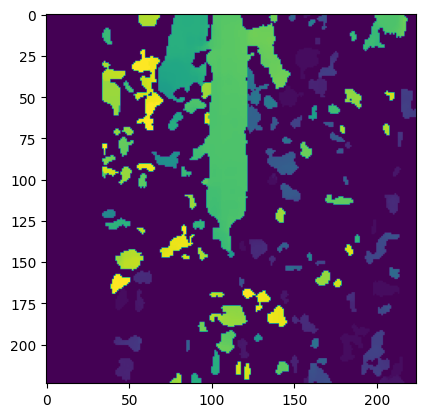

In [329]:
plt.imshow(X_train[0])

In [286]:
X_train[10]

array([None, None], dtype=object)

In [262]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import tensorflow as tf

class StereoDistance(Model):
	def __init__(self, classes=1):
		super(StereoDistance, self).__init__()
		self.chan_dim=-1
  
		self.shared_layer = Sequential([
			layers.Conv2D(64, (7, 7), padding="same", strides=(2,2)),
			layers.Activation("relu"),
			layers.BatchNormalization(),
			layers.MaxPooling2D(pool_size=(2, 2))
		])

		self.concat = layers.Concatenate(axis=3)

		self.layer1 = Sequential([
			layers.Conv2D(128, (5, 5), padding="same", strides=(2,2)),
			layers.Activation("relu"),
			# layers.BatchNormalization(),
			layers.MaxPooling2D(pool_size=(2, 2))
		])

		self.layer2 = Sequential([
			layers.Conv2D(12, (3, 3), padding="same"),
			layers.Activation("relu"),
			# layers.BatchNormalization(),
			layers.MaxPooling2D(pool_size=(2, 2))
		])

		self.layer3 = Sequential([
			layers.Conv2D(64, (3, 3), padding="same"),
			layers.Activation("relu"),
			# layers.BatchNormalization(),
			layers.MaxPooling2D(pool_size=(2, 2))
		])
  
		self.layer4 = Sequential([
			layers.Conv2D(64, (3, 3), padding="same"),
			layers.Activation("relu"),
			# layers.BatchNormalization(),
			layers.MaxPooling2D(pool_size=(2, 2))
		])
  
		self.avg_pool = layers.GlobalAvgPool2D()

		# self.flatten = layers.Flatten()

		self.fc1 = Sequential([
			layers.Dense(64),
			layers.Activation("relu"),
			layers.BatchNormalization(),
			layers.Dropout(0.5)
		])
  
		self.fc2 = Sequential([
			layers.Dense(classes),
			layers.Activation("linear")
		])
  
  
	def call(self, inputs):
		# left_inputs, right_inputs = tf.split(inputs, num_or_size_splits=2, axis=3)
		# left = self.left_layer(left_inputs)
		# right = self.right_layer(right_inputs)
		# x = self.concat([left, right])
		x = inputs
		x = self.layer1(x)
		x = self.layer2(x)
		x = self.layer3(x)
		x = self.layer4(x)
		x = self.avg_pool(x)
		# x = self.flatten(x)
		x = self.fc1(x)
		x = self.fc2(x)
  
		return x



In [272]:
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

model = StereoDistance()
model.build(input_shape=(None, 224,224,2))

model.compile(optimizer=Adam(), 
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae','mse'])

model.summary()


Model: "stereo_distance_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_522 (Sequential)  (None, 56, 56, 64)       6336      
                                                                 
 sequential_523 (Sequential)  (None, 28, 28, 64)       36928     
                                                                 
 sequential_524 (Sequential)  (None, 14, 14, 64)       36928     
                                                                 
 sequential_525 (Sequential)  (None, 7, 7, 64)         36928     
                                                                 
 global_average_pooling2d_8   multiple                 0         
 (GlobalAveragePooling2D)                                        
                                                                 
 sequential_526 (Sequential)  (None, 64)               4416      
                                                

In [169]:
# model(X_train[0])

In [273]:
import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

history = model.fit(X_train, 
                   y_train, 
                   epochs=100, 
                   batch_size=128,
                   validation_data=(X_test, y_test))

No GPU found
Epoch 1/100


2022-11-16 08:12:46.930070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 08:12:46.930553: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


3/3 [==============================] - 4s 964ms/step - loss: 0.4274 - mae: 0.6004 - mse: 0.4274 - val_loss: 0.4545 - val_mae: 0.6185 - val_mse: 0.4545
Epoch 2/100
3/3 [==============================] - 3s 909ms/step - loss: 0.3623 - mae: 0.5525 - mse: 0.3623 - val_loss: 0.4130 - val_mae: 0.5839 - val_mse: 0.4130
Epoch 3/100
3/3 [==============================] - 3s 936ms/step - loss: 0.3109 - mae: 0.5062 - mse: 0.3109 - val_loss: 0.3606 - val_mae: 0.5372 - val_mse: 0.3606
Epoch 4/100
3/3 [==============================] - 3s 894ms/step - loss: 0.2769 - mae: 0.4773 - mse: 0.2769 - val_loss: 0.3112 - val_mae: 0.4893 - val_mse: 0.3112
Epoch 5/100
3/3 [==============================] - 3s 829ms/step - loss: 0.2414 - mae: 0.4392 - mse: 0.2414 - val_loss: 0.2564 - val_mae: 0.4295 - val_mse: 0.2564
Epoch 6/100
3/3 [==============================] - 3s 877ms/step - loss: 0.2084 - mae: 0.4032 - mse: 0.2084 - val_loss: 0.2477 - val_mae: 0.4205 - val_mse: 0.2477
Epoch 7/100
3/3 [=================

In [274]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 12ms/step - loss: 0.0646 - mae: 0.2197 - mse: 0.0646


[0.06456916779279709, 0.2196619212627411, 0.06456916779279709]

In [275]:
model.predict(X_test[:2])

1/1 [==============================] - 0s 104ms/step


array([[0.5483803 ],
       [0.55539393]], dtype=float32)

In [277]:
y_test[:2]

array([0.8       , 0.86666667])